#**CycleGAN: Edges to Portrait**

**Model** 
> Generator: ResNet  
> Discriminator: PatchGAN  
> GAN Loss: LSGAN
  
**Version** 
> v1: first version of CycleGAN  
> v2: train discriminator if loss is bigger than criterion  
> v3: add ReplayBuffer for training discriminator  
  
**Data**  
> https://www.kaggle.com/kairess/edges2portrait  
> https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/  

**Reference**  
> https://github.com/aitorzip/PyTorch-CycleGAN/blob/master/models.py

In [1]:
import torch
import torch.nn as nn
import torchvision.utils as utils
import torch.optim as optim 
import torchvision.transforms as transforms
from torch.autograd import Variable
import itertools

import cv2
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
import pickle

In [2]:
workers = 2
batch_size = 4
input_nc = 3
output_nc = 3
image_size = 256

epochs = 50
lr = 0.0002
beta1 = 0.5
lamb = 100
isCuda = True

device = torch.device("cuda:0" if (torch.cuda.is_available() and isCuda) else "cpu")
torch.backends.cudnn.benchmark = True

model_saved_dir = "/content/drive/MyDrive/Colab Notebooks/AirForce/model/CycleGAN"

print("Device: ", end="")
print(device)

Device: cuda:0


In [3]:
def cuda_status():
  print(torch.cuda.get_device_name(0))
  print('Memory Usage:')
  print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
  print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

## Data Loading

In [4]:
import os.path
from google.colab import files

if os.path.isfile('/content/kaggle.json'):
  print("Already kaggle.json exsits.")
else:
  files.upload()
  !mkdir -p ~/.kaggle
  !cp kaggle.json ~/.kaggle/ 
  !chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d arnaud58/horse2zebra

if os.path.isdir('/content/horse2zebra'):
  print("Already unzip.")
else:
  !unzip -q horse2zebra.zip
  print("Unzip Complete!")

Saving kaggle.json to kaggle.json
 80% 89.0M/111M [00:03<00:01, 17.0MB/s]
100% 111M/111M [00:03<00:00, 35.7MB/s] 
Unzip Complete!


In [5]:
class PairDataset(torch.utils.data.Dataset):
  def __init__(self, root_dir, train=True, A_names = [], B_names = []):
    self.root_dir = root_dir
    self.As = []
    self.Bs = []

    if train:
      nameStr = 'train'
    else:
      nameStr = 'test'

    if len(A_names) == 0:
      for filename in glob(root_dir + F"/{nameStr}A/*.jpg"):
        self.As.append(self.getImg(filename))
      for filename in glob(root_dir + F"/{nameStr}B/*.jpg"):
        self.Bs.append(self.getImg(filename))
    else:
      for A_name in A_names:
        self.As.append(self.getImg(root_dir + F"/{nameStr}A/{A_name}.jpg"))
      for B_name in B_names:
        self.Bs.append(self.getImg(root_dir + F"/{nameStr}B/{B_name}.jpg"))

  def __len__(self):
    return min(len(self.As), len(self.Bs))

  def __getitem__(self, idx):
    imgA = self.As[idx]
    imgB = self.Bs[idx]
    return (imgA, imgB)

  def getImg(self, filename):
    img = cv2.imread(filename)
    img = img/127.5 - 1  # Normalize
    img = np.einsum('ijk->kij', img)
    return img

dataset = PairDataset('/content/horse2zebra', train=True)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=workers)

test_dataset = PairDataset('/content/horse2zebra', train=False)

A_names = [600, 50, 910, 1750, 4420, 7700, 20, 140, 950, 4470]
B_names = [4890, 7060, 5810, 10160, 2290, 2810, 120, 3270, 1270, 5030]
for i in range(10):
  A_names[i] = 'n02381460_'+str(A_names[i])
  B_names[i] = 'n02391049_'+str(B_names[i])
sample_dataset = PairDataset('/content/horse2zebra', train=False, A_names = A_names, B_names = B_names)

In [6]:
def ImgForPlot(img):
  img = np.einsum('ijk->jki', img)
  img = (127.5*(img+1)).astype(np.uint8)
  return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

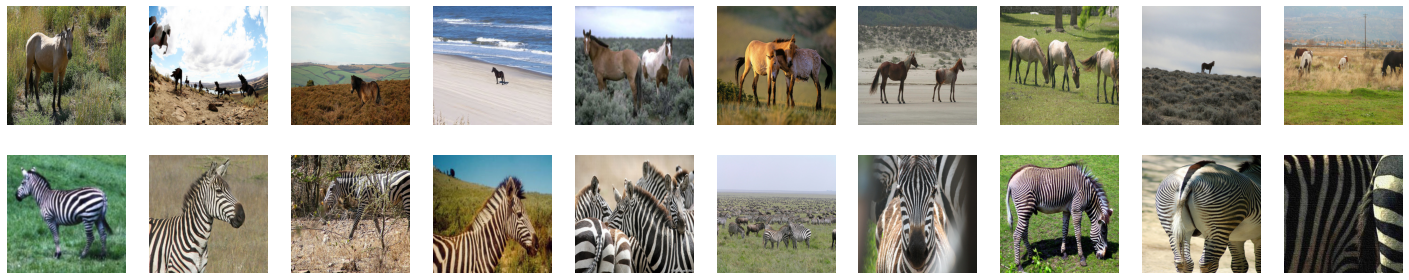

In [7]:
fig = plt.figure(figsize=(25,5))

for k in range(10):
  imgA, imgB = sample_dataset[k]
  ax = fig.add_subplot(2, 10, k+1)
  ax.imshow(ImgForPlot(imgA))
  ax.axis("off")
  ax = fig.add_subplot(2, 10, k+11)
  ax.imshow(ImgForPlot(imgB))
  ax.axis("off")

plt.show()

## Generator  

Encoder(Downsampling) → Transformer(Residual Block x9) → Decoder(Upsampling)  
  
Encoder:  
> Conv #1: ReflectionPad(3) → Conv(in_channels, 64, 7) → InstanceNorm → ReLU  
> Conv #2: Conv(64, 128, 3, 2, 1) → InstanceNorm → ReLU  
> Conv #3: Conv(128, 256, 3, 2, 1) → InstanceNorm → ReLU
  
Residual Block: 
> ReflectionPad(1) → Conv(256, 256, 3) → InstanceNorm → ReLU  
> → ReflectionPad(1) → Conv(256, 256, 3) → InstanceNorm → Add

Decoder:  
> Conv #1: ConvT(256, 128, 3, 2, 1, out_padding=1) → InstanceNorm → ReLU  
> Conv #2: ConvT(128, 64, 3, 2, 1, out_padding=1) → InstanceNorm → ReLU  
> Conv #3: ReflectionPad(3) → Conv(64, out_channels, 7) → Tanh



In [8]:
def weights_init(m):
  classname = m.__class__.__name__
  if classname.find('Conv') != -1:
    nn.init.normal_(m.weight.data, 0.0, 0.02)
  elif classname.find('BatchNorm') != -1:
    nn.init.normal_(m.weight.data, 1.0, 0.02)
    nn.init.constant_(m.bias.data, 0)

In [9]:
class Res_Block(nn.Module):
  def __init__(self, n_features):
    super(Res_Block, self).__init__()
    self.main = nn.Sequential(
        nn.ReflectionPad2d(1),
        nn.Conv2d(n_features, n_features, 3),
        nn.InstanceNorm2d(n_features),
        nn.ReLU(inplace=True),

        nn.ReflectionPad2d(1),
        nn.Conv2d(n_features, n_features, 3),
        nn.InstanceNorm2d(n_features)
    )

  def forward(self, x):
    return x + self.main(x)

class Generator(nn.Module):
  def __init__(self, in_channels, out_channels, n_res_block=9):
    super(Generator, self).__init__()
    self.n_res_block = n_res_block
    self.enc = nn.Sequential(
        nn.ReflectionPad2d(3),
        nn.Conv2d(in_channels, 64, 7),
        nn.InstanceNorm2d(64),
        nn.ReLU(inplace=True),

        nn.Conv2d(64, 128, 3, stride=2, padding=1),
        nn.InstanceNorm2d(128),
        nn.ReLU(inplace=True),

        nn.Conv2d(128, 256, 3, stride=2, padding=1),
        nn.InstanceNorm2d(256),
        nn.ReLU(inplace=True)
    )

    self.dec = nn.Sequential(
        nn.ConvTranspose2d(256, 128, 3, 2, 1, output_padding=1),
        nn.InstanceNorm2d(128),
        nn.ReLU(inplace=True),

        nn.ConvTranspose2d(128, 64, 3, 2, 1, output_padding=1),
        nn.InstanceNorm2d(64),
        nn.ReLU(inplace=True),

        nn.ReflectionPad2d(3),
        nn.Conv2d(64, out_channels, 7),
        nn.Tanh()
    )

    self.res = []
    for _ in range(n_res_block):
      block = Res_Block(256).to(device)
      block.apply(weights_init)
      self.res.append(block)

  def forward(self, x):
    x = self.enc(x)
    for i in range(self.n_res_block):
      x = self.res[i](x)
    x = self.dec(x)
    return x

## Discriminator

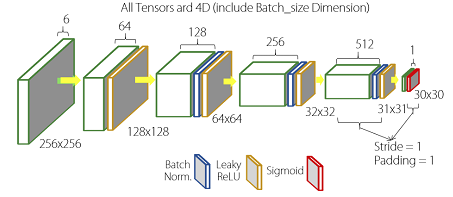

In [10]:
class Discriminator(nn.Module):
  def __init__(self, in_channels):
    super(Discriminator, self).__init__()
    self.main = nn.Sequential(
        # 256x256x1
        nn.Conv2d(in_channels, 64, 4, 2, 1, bias=False),
        nn.LeakyReLU(0.2, inplace=True),
        # 128x128x64
        nn.Conv2d(64, 128, 4, 2, 1, bias=False),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(0.2, inplace=True),
        # 64x64x128
        nn.Conv2d(128, 256, 4, 2, 1, bias=False),
        nn.BatchNorm2d(256),
        nn.LeakyReLU(0.2, inplace=True),
        # 32x32x256
        nn.Conv2d(256, 512, 4, 1, 1, bias=False),
        nn.BatchNorm2d(512),
        nn.LeakyReLU(0.2, inplace=True),
        # 31x31x512
        nn.Conv2d(512, 1, 4, 1, 1, bias=False),
        nn.Sigmoid()
        # 30x30x1
    )

  def forward(self, x):
    return self.main(x)

## Making models & Weight initialization

In [11]:
netG_A2B = Generator(input_nc, output_nc, n_res_block=9).to(device)
netG_B2A = Generator(input_nc, output_nc, n_res_block=9).to(device)
netD_A = Discriminator(input_nc).to(device)
netD_B = Discriminator(output_nc).to(device)

In [ ]:
netG_A2B.apply(weights_init)
netG_B2A.apply(weights_init)
netD_A.apply(weights_init)
netD_B.apply(weights_init)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

## (Option) Load from drive


In [ ]:
model_name = 'CycleGAN_h2z_v2.1'

img_list_A2B_path = F"{model_saved_dir}/{model_name}_img_list_A2B.txt"
img_list_B2A_path = F"{model_saved_dir}/{model_name}_img_list_B2A.txt"
G_losses_path = F"{model_saved_dir}/{model_name}_G_losses.txt"
D_A_losses_path = F"{model_saved_dir}/{model_name}_D_A_losses.txt"
D_B_losses_path = F"{model_saved_dir}/{model_name}_D_B_losses.txt"

with open(img_list_A2B_path, 'rb') as f:
  img_list_A2B = pickle.load(f)
with open(img_list_B2A_path, 'rb') as f:
  img_list_B2A = pickle.load(f)
with open(G_losses_path, 'rb') as f:
  G_losses = pickle.load(f)
with open(D_A_losses_path, 'rb') as f:
  D_A_losses = pickle.load(f)
with open(D_B_losses_path, 'rb') as f:
  D_B_losses = pickle.load(f)

In [13]:
G_A2B_path = F"{model_saved_dir}/{model_name}_G_A2B.pt"
G_B2A_path = F"{model_saved_dir}/{model_name}_G_B2A.pt"
D_A_path = F"{model_saved_dir}/{model_name}_D_A.pt"
D_B_path = F"{model_saved_dir}/{model_name}_D_B.pt"

netG_A2B.load_state_dict(torch.load(G_A2B_path))
netG_B2A.load_state_dict(torch.load(G_B2A_path))
netD_A.load_state_dict(torch.load(D_A_path))
netD_B.load_state_dict(torch.load(D_B_path))

<All keys matched successfully>

## Loss Functions and Optimizers


In [14]:
l1_loss = nn.L1Loss()
mse_loss = nn.MSELoss()

sample_imgs = []
for i in range(10):
  imgA, imgB = sample_dataset[i]
  sample_imgs.append((imgA, imgB))

sampleA = torch.FloatTensor(np.array([x for x,y in sample_imgs])).cuda()
sampleB = torch.FloatTensor(np.array([y for x,y in sample_imgs])).cuda()

real_num = 1
fake_num = 0

optimizerD_A = optim.Adam(netD_A.parameters(), lr=lr, betas=(beta1,0.999))
optimizerD_B = optim.Adam(netD_B.parameters(), lr=lr, betas=(beta1,0.999))
optimizerG = optim.Adam(itertools.chain(netG_A2B.parameters(), netG_B2A.parameters()), lr=lr, betas=(beta1, 0.999))

In [15]:
G_losses, D_A_losses, D_B_losses = [], [], []

## Training

In [ ]:
start_epoch = 0
continueTrain = True

if start_epoch == 0 and not continueTrain:
  img_list_A2B, img_list_B2A = [], []
  G_losses, D_A_losses, D_B_losses = [], [], []

model_name = 'CycleGAN_h2z_autosave'
G_A2B_path = F"{model_saved_dir}/{model_name}_G_A2B.pt"
G_B2A_path = F"{model_saved_dir}/{model_name}_G_B2A.pt"
D_A_path = F"{model_saved_dir}/{model_name}_D_A.pt"
D_B_path = F"{model_saved_dir}/{model_name}_D_B.pt"
img_list_A2B_path = F"{model_saved_dir}/{model_name}_img_list_A2B.txt"
img_list_B2A_path = F"{model_saved_dir}/{model_name}_img_list_B2A.txt"
G_losses_path = F"{model_saved_dir}/{model_name}_G_losses.txt"
D_A_losses_path = F"{model_saved_dir}/{model_name}_D_A_losses.txt"
D_B_losses_path = F"{model_saved_dir}/{model_name}_D_B_losses.txt"

netD_A.train()
netD_B.train()
netG_A2B.train()
netG_B2A.train()

stop_D_train_criterion = 0.1

for ep in range(start_epoch, epochs):
  for batch_idx, (imgA, imgB) in enumerate(dataloader, 0):
    isDAtrain, isDBtrain = False, False

    b_size = imgA.shape[0]
    real_A = Variable(imgA.type(torch.FloatTensor)).cuda()
    real_B = Variable(imgB.type(torch.FloatTensor)).cuda()

    real_label = torch.full((b_size, 1, 30, 30), real_num, device=device)
    fake_label = torch.full((b_size, 1, 30, 30), fake_num, device=device)
    real_label = real_label.type(torch.cuda.FloatTensor)
    fake_label = fake_label.type(torch.cuda.FloatTensor)

    # 1. Update Generator A2B and B2A
    optimizerG.zero_grad()

    # 1-1. Identity Loss
    same_B = netG_A2B(real_B)
    loss_identity_B = l1_loss(same_B, real_B) * 5.0

    same_A = netG_B2A(real_A)
    loss_identity_A = l1_loss(same_A, real_A) * 5.0

    # 1-2. GAN Loss
    fake_B = netG_A2B(real_A)
    pred_fake = netD_B(fake_B)
    loss_GAN_A2B = mse_loss(pred_fake, real_label)
    DB_G_A = pred_fake.mean().item()

    fake_A = netG_B2A(real_B)
    pred_fake = netD_A(fake_A)
    loss_GAN_B2A = mse_loss(pred_fake, real_label)
    DA_G_B = pred_fake.mean().item()

    # 1-3. Reconstruction Loss
    recon_A = netG_B2A(fake_B)
    loss_recon_A = l1_loss(recon_A, real_A) * 10.0

    recon_B = netG_A2B(fake_A)
    loss_recon_B = l1_loss(recon_B, real_B) * 10.0

    # 1-4. Total Loss
    loss_G = loss_identity_A + loss_identity_B + loss_GAN_A2B + loss_GAN_B2A + loss_recon_A + loss_recon_B
    loss_G.backward()
    optimizerG.step()


    # 2. Update Discriminator A
    optimizerD_A.zero_grad()

    pred_real = netD_A(real_A)
    loss_DA_real = mse_loss(pred_real, real_label)
    DA_A = pred_real.mean().item()

    pred_fake = netD_A(fake_A.detach())
    loss_DA_fake = mse_loss(pred_fake, fake_label)

    loss_DA = 0.5 * (loss_DA_real + loss_DA_fake)
    
    if loss_DA.item() > stop_D_train_criterion:
      isDAtrain = True
      loss_DA.backward()
      optimizerD_A.step()


    # 3. Update Discriminator B
    optimizerD_B.zero_grad()

    pred_real = netD_B(real_B)
    loss_DB_real = mse_loss(pred_real, real_label)
    DB_B = pred_real.mean().item()

    pred_fake = netD_B(fake_B.detach())
    loss_DB_fake = mse_loss(pred_fake, fake_label)

    loss_DB = 0.5 * (loss_DB_real + loss_DB_fake)

    if loss_DB.item() > stop_D_train_criterion:
      isDBtrain = True
      loss_DB.backward()
      optimizerD_B.step()

    if batch_idx % 10 == 9 or batch_idx == (len(dataloader)-1):
      if isDAtrain and isDBtrain:
        print('[%2d/%2d][%3d/%3d]\tLoss_G: %.4f\tLoss_D_A: %.4f\tLoss_D_B: %.4f\n\t\t\tD(A): %.4f\tD(G(B)): %.4f\tD(B): %.4f\tD(G(A)): %.4f' 
              % (ep+1, epochs, batch_idx+1, len(dataloader), loss_G.item(), loss_DA.item(), loss_DB.item(), DA_A, DA_G_B, DB_B, DB_G_A))
      elif isDAtrain and not isDBtrain:
        print('[%2d/%2d][%3d/%3d]\tLoss_G: %.4f\tLoss_D_A: %.4f\n\t\t\tD(A): %.4f\tD(G(B)): %.4f\tD(G(A)): %.4f' 
              % (ep+1, epochs, batch_idx+1, len(dataloader), loss_G.item(), loss_DA.item(), DA_A, DA_G_B, DB_G_A))
      elif isDBtrain and not isDAtrain:
        print('[%2d/%2d][%3d/%3d]\tLoss_G: %.4f\tLoss_D_B: %.4f\n\t\t\tD(G(B)): %.4f\tD(B): %.4f\tD(G(A)): %.4f' 
              % (ep+1, epochs, batch_idx+1, len(dataloader), loss_G.item(), loss_DB.item(), DA_G_B, DB_B, DB_G_A))
      else:
        print('[%2d/%2d][%3d/%3d]\tLoss_G: %.4f\tD(G(B)): %.4f\tD(G(A)): %.4f' 
              % (ep+1, epochs, batch_idx+1, len(dataloader), loss_G.item(), DA_G_B, DB_G_A))
      
      G_losses.append(loss_G.item())
      D_A_losses.append(loss_DA.item())
      D_B_losses.append(loss_DB.item())
    
    temp_loss_DA = loss_DA.item()
    temp_loss_DB = loss_DB.item()


  with torch.no_grad():
    fake = netG_A2B(sampleA).detach().cpu()
    img_list_A2B.append(fake)
    fake = netG_B2A(sampleB).detach().cpu()
    img_list_B2A.append(fake)

  torch.save(netG_A2B.state_dict(), G_A2B_path)
  torch.save(netG_B2A.state_dict(), G_B2A_path)
  torch.save(netD_A.state_dict(), D_A_path)
  torch.save(netD_B.state_dict(), D_B_path)

  with open(img_list_A2B_path, 'wb') as f:
    pickle.dump(img_list_A2B, f)
  with open(img_list_B2A_path, 'wb') as f:
    pickle.dump(img_list_B2A, f)
  with open(G_losses_path, 'wb') as f:
    pickle.dump(G_losses, f)
  with open(D_A_losses_path, 'wb') as f:
    pickle.dump(D_A_losses, f)
  with open(D_B_losses_path, 'wb') as f:
    pickle.dump(D_B_losses, f)

[45/50][ 20/267]	Loss_G: 5.7985	D(G(B)): 0.3098	D(G(A)): 0.1351
[45/50][ 30/267]	Loss_G: 4.6394	Loss_D_A: 0.1670
			D(A): 0.9351	D(G(B)): 0.5479	D(G(A)): 0.1105
[45/50][ 40/267]	Loss_G: 4.9464	D(G(B)): 0.2610	D(G(A)): 0.3186
[45/50][ 50/267]	Loss_G: 4.8174	D(G(B)): 0.0984	D(G(A)): 0.3473
[45/50][ 60/267]	Loss_G: 4.8672	D(G(B)): 0.1252	D(G(A)): 0.1938
[45/50][ 70/267]	Loss_G: 4.3524	D(G(B)): 0.3146	D(G(A)): 0.2016
[45/50][ 80/267]	Loss_G: 4.6954	Loss_D_A: 0.1039
			D(A): 0.6649	D(G(B)): 0.2581	D(G(A)): 0.3743
[45/50][ 90/267]	Loss_G: 4.4532	Loss_D_A: 0.1130	Loss_D_B: 0.1064
			D(A): 0.6798	D(G(B)): 0.3058	D(B): 0.7028	D(G(A)): 0.2977
[45/50][100/267]	Loss_G: 5.0920	D(G(B)): 0.2394	D(G(A)): 0.1461
[45/50][110/267]	Loss_G: 4.6971	D(G(B)): 0.2109	D(G(A)): 0.2834
[45/50][120/267]	Loss_G: 5.1916	D(G(B)): 0.2159	D(G(A)): 0.0962
[45/50][130/267]	Loss_G: 5.1649	D(G(B)): 0.1425	D(G(A)): 0.2982
[45/50][140/267]	Loss_G: 4.1713	D(G(B)): 0.3302	D(G(A)): 0.3106
[45/50][150/267]	Loss_G: 4.6644	Loss_D_

### Check last fake images

In [24]:
fig = plt.figure(figsize=(20, 48))

imgsA2B = img_list_A2B[-1].tolist()
imgsB2A = img_list_B2A[-1].tolist()

for j in range(10):
  samA, samB = sample_dataset[j]
  ax = fig.add_subplot(10, 4, 2*j+1)
  ax.imshow(ImgForPlot(samB))
  ax.axis("off")
  ax.set_title("Real Zebra")
  ax = fig.add_subplot(10, 4, 2*j+2)
  ax.imshow(ImgForPlot(imgsB2A[j]))
  ax.axis("off")
  ax.set_title("Generated Horse")
  ax = fig.add_subplot(10, 4, 2*j+21)
  ax.imshow(ImgForPlot(samA))
  ax.axis("off")
  ax.set_title("Real Horse")
  ax = fig.add_subplot(10, 4, 2*j+22)
  ax.imshow(ImgForPlot(imgsA2B[j]))
  ax.axis("off")
  ax.set_title("Generated Zebra")

plt.show()

Output hidden; open in https://colab.research.google.com to view.

### Plot losses of generator and discriminator

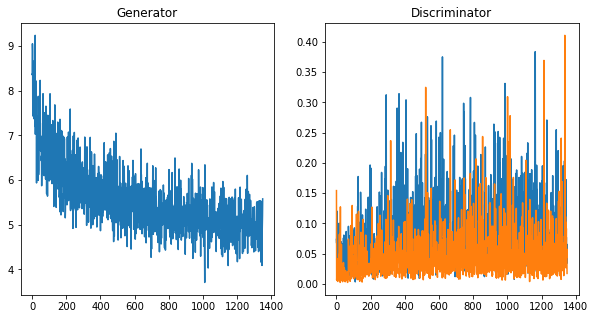

In [ ]:
fig = plt.figure(figsize=(10, 5))

ax = fig.add_subplot(1, 2, 1)
ax.plot(range(len(G_losses)), G_losses)
ax.set_title("Generator")
ax = fig.add_subplot(1, 2, 2)
ax.plot(range(len(D_A_losses)), D_A_losses)
ax.plot(range(len(D_B_losses)), D_B_losses)
ax.set_title("Discriminator")

plt.show()

## Save models and images in drive

In [ ]:
model_name = 'CycleGAN_h2z_v2.1'

G_A2B_path = F"{model_saved_dir}/{model_name}_G_A2B.pt"
G_B2A_path = F"{model_saved_dir}/{model_name}_G_B2A.pt"
D_A_path = F"{model_saved_dir}/{model_name}_D_A.pt"
D_B_path = F"{model_saved_dir}/{model_name}_D_B.pt"
torch.save(netG_A2B.state_dict(), G_A2B_path)
torch.save(netG_B2A.state_dict(), G_B2A_path)
torch.save(netD_A.state_dict(), D_A_path)
torch.save(netD_B.state_dict(), D_B_path)

img_list_A2B_path = F"{model_saved_dir}/{model_name}_img_list_A2B.txt"
img_list_B2A_path = F"{model_saved_dir}/{model_name}_img_list_B2A.txt"
with open(img_list_A2B_path, 'wb') as f:
  pickle.dump(img_list_A2B, f)
with open(img_list_B2A_path, 'wb') as f:
  pickle.dump(img_list_B2A, f)

print(F"Saved {model_name} Completed!")

Saved CycleGAN_h2z_v2.1 Completed!


## Animation

In [ ]:
from matplotlib.animation import FuncAnimation
from matplotlib import rcParams
from IPython.display import HTML, clear_output

rcParams['animation.embed_limit'] = 2**128

ims = []
SIZE = 10
fig = plt.figure(figsize=(SIZE, SIZE))

imgB2As = img_list_B2A[0].tolist()
imgA2Bs = img_list_A2B[0].tolist()
for j in range(10):
  ax = fig.add_subplot(4, 5, j+1)
  im = ax.imshow(ImgForPlot(imgB2As[j]))
  ax.axis("off")
  ims.append(im)
  ax = fig.add_subplot(4, 5, j+11)
  im = ax.imshow(ImgForPlot(imgA2Bs[j]))
  ax.axis("off")
  ims.append(im)

def init():
  for j in range(20):
    ims[j].set_data(([[]*5]*4))

  return tuple(ims)

def update(frame):
  imgB2As = img_list_B2A[frame].tolist()
  imgA2Bs = img_list_A2B[frame].tolist()
  
  for j in range(10):
    img = imgB2As[j]
    ims[j*2].set_array(ImgForPlot(img))
    img = imgA2Bs[j]
    ims[j*2+1].set_array(ImgForPlot(img))

  return tuple(ims)

ani = FuncAnimation(fig=fig, init_func=init, func=update, interval=500, blit=True, frames=range(len(img_list_A2B)))

plt.show()
clear_output(wait = True)

HTML(ani.to_jshtml())

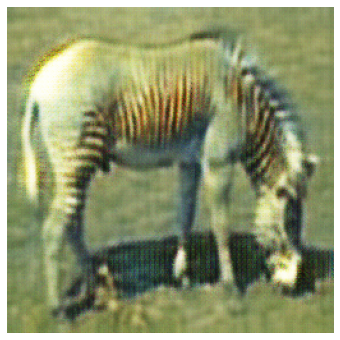

In [17]:
from matplotlib.animation import FuncAnimation
from matplotlib import rcParams
from IPython.display import HTML, clear_output

rcParams['animation.embed_limit'] = 2**128

SIZE = 6
idx = 7
isA2B = False

fig = plt.figure(figsize=(SIZE, SIZE))

if isA2B:
  img = img_list_A2B[0].tolist()
else:
  img = img_list_B2A[0].tolist()
im = plt.imshow(ImgForPlot(img[idx]))
plt.axis('off')

def init():
  im.set_data(ImgForPlot(img[idx]))
  return [im]

def update(frame):
  if isA2B:
    img = img_list_A2B[frame].tolist()
  else:
    img = img_list_B2A[frame].tolist()
  im.set_array(ImgForPlot(img[idx]))

  return [im]

ani = FuncAnimation(fig=fig, init_func=init, func=update, interval=500, blit=True, frames=range(len(img_list_A2B)))

plt.show()
clear_output(wait = True)

HTML(ani.to_jshtml())

## Test

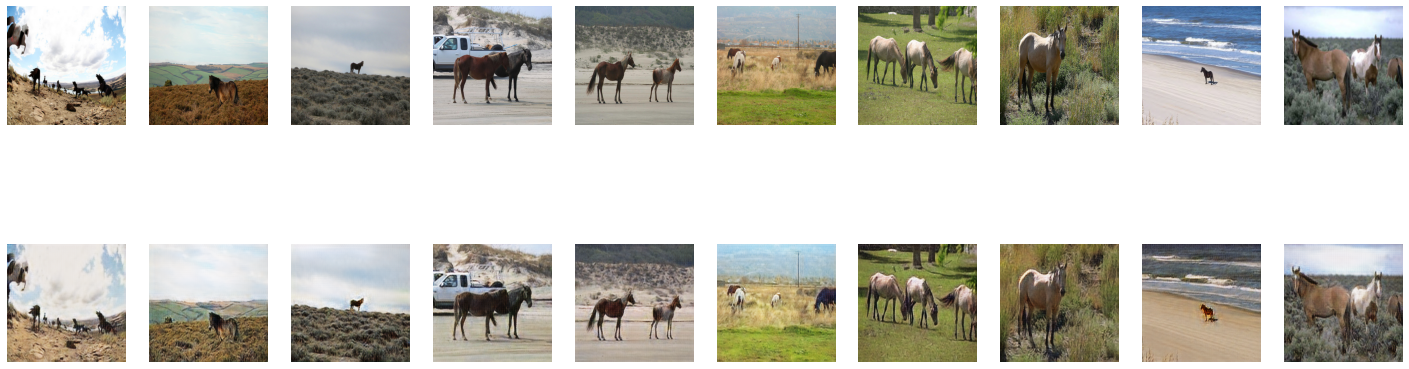

In [ ]:
netG_A2B.eval()
netD_B.eval()

inputs, outputs, probs = [], [], []
for idx, imgA in enumerate(test_dataset.As):
  inputs.append(imgA)
  output = netG_A2B(torch.Tensor(imgA).unsqueeze_(0).cuda())
  probs.append(netD_B(output).mean().item())
  outputs.append(output.squeeze(0).cpu().detach().numpy())
  del output
  torch.cuda.empty_cache()
  if idx == 11:
    break

probs = np.array(probs)

fig = plt.figure(figsize=(25,8))

ranks = probs.argsort()
for i, r in enumerate(ranks[:10]):
  ax = fig.add_subplot(2, 10, i+1)
  ax.imshow(ImgForPlot(inputs[r]))
  ax.axis('off')
  ax = fig.add_subplot(2, 10, i+11)
  ax.imshow(ImgForPlot(outputs[r]))
  ax.axis('off')